#  ![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Pictograms-nps-misc-rattlesnakes-2.svg/256px-Pictograms-nps-misc-rattlesnakes-2.svg.png =44x44) Magick AI - SnakeCharmer V3

**Purpose**: prototyping experiments supporting project Panto, and Akasha. Provides several video frame autoencoder architechtures from shallow and dense, to deep convolutional, temporally predictive and variational.


---


**References**: Heavily adapted from[ Keras AE Tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) by [Francois Chollet](https://twitter.com/fchollet), and others where commented inline.



In [3]:
#@title Includes
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import sys
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.python.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.python.keras.layers import Concatenate, ConvLSTM2D, MaxPooling2D, Add, concatenate
from tensorflow.python.keras.layers import UpSampling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Activation, LeakyReLU
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#@title Data Preparation

#VIDEO_PATH = 'drive/My Drive/portraitAsHSV.avi'
#VIDEO_PATH = 'drive/My Drive/portraitAsRGBWithFlowArrows.avi'
VIDEO_PATH = 'drive/My Drive/portraitAsRGB.avi'

cap = cv2.VideoCapture(VIDEO_PATH)
#cap = cv2.resize(cap, (640, 360))
#Reads the frame count, width and height of the video supplied
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frames:", length)
print()

l_frames = [cap.read()[1] for i in range(length)] #discard return value of cap.read(), keep array
#print(l_frames[0]) #list of frames
print(type(l_frames), "'l_frames'")
print("items:", len(l_frames), )
print("item shape:", l_frames[0].shape, l_frames[0].dtype)
print()

frames = np.stack(l_frames, axis=0) #combine all 3d frames to a 4d tensor (batch dimension first)
#frames = frames / 255
#print(frames[0]) #tensor of frames
print(type(frames),"'frames'")
print("ndim:", frames.ndim, frames[:].shape)
print("frame shape:", frames[0].shape, frames[0].dtype)
print()

INPUT_SIZE = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)*cap.get(cv2.CAP_PROP_FRAME_HEIGHT)*3 )
print("Frame Width:", cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Frame Height:", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Frame Size:", INPUT_SIZE)
print()

## https://stackoverflow.com/questions/41758385/resizing-images-in-keras-imagedatagenerator-flow-methods
import skimage
from skimage import transform
new_shape = (640,360,3) #drop resoltion by one factor
frames_half = np.empty(shape=(frames.shape[0],)+new_shape, dtype='float32') #coercing to float32 to prevent later autoconversion to float64
for idx in range(frames.shape[0]):
    frames_half[idx] = skimage.transform.resize(frames[idx]/frames.max(), new_shape) #normalizing to max value to improve training
print()
print("'frames'",frames.dtype, frames.shape)
print(frames[0,0])
print()
print("'frames_half'",frames_half.dtype, frames_half.shape)
print(frames_half[0,0])
print()  

##(disabled) convert values to float between zero (0) and one (1)
#print("datatype: ", frames.dtype)
#print(frames[0,0])
#print()
#if frames.dtype != "float32": 
#  frames = frames.astype('float32') / 255 #crashy method, handling this inline with training in deep models
#  print("after coercing to", frames.dtype)
#  print(frames[0,0])
#  print()
#else:
#  print("already float32, no conversion applied")
#print()

##(disabled) flatten images for Dense (non-conv)
#x_train = frames.reshape(length,-1) #2d array (flattened image, frames)
#x_train.shape
#print(x_train[0])
#print("obj 'x_train'", x_train.shape)
#print("obj 'x_train' frame", x_train[0].shape)
#print()



Frames: 47

<class 'list'> 'l_frames'
items: 47
item shape: (1280, 720, 3) uint8

<class 'numpy.ndarray'> 'frames'
ndim: 4 (47, 1280, 720, 3)
frame shape: (1280, 720, 3) uint8

Frame Width: 720.0
Frame Height: 1280.0
Frame Size: 2764800



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



'frames' uint8 (47, 1280, 720, 3)
[[207 210 208]
 [207 210 208]
 [207 210 208]
 ...
 [248 251 249]
 [249 252 250]
 [249 252 250]]

'frames_half' float32 (47, 640, 360, 3)
[[0.8098039  0.8215686  0.8137255 ]
 [0.8088235  0.82058823 0.8127451 ]
 [0.80784315 0.81960785 0.8117647 ]
 ...
 [0.9676471  0.9794118  0.97156864]
 [0.9735294  0.9852941  0.97745097]
 [0.97843134 0.99019605 0.9823529 ]]



In [3]:
#@title Shallow Convolutional AE Model from SnakeCharmer V2

#frames_in = frames
frames_in = frames_half
encoding_dim = 128 #encoder compressed vector length
#encoding_dim = (16, 16, 16)
kernel_size = (3, 3)

## define keras model
#input_img = Input(shape=(INPUT_SIZE,))
#input_img = Input(shape=(720, 1280, 3))
input_img = Input(shape=frames_in[0].shape)

# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Conv2D(filters = encoding_dim, 
                 kernel_size = kernel_size, 
                 strides = (1, 1), 
                 padding = 'same', 
                 data_format = "channels_last", 
                 activation = 'relu'
                )(input_img)

# "decoded" is the lossy reconstruction of the input
#decoded = Dense(INPUT_SIZE, activation='sigmoid')(encoded)
decoded = Conv2DTranspose(frames_in.shape[3], 
                          kernel_size, 
                          strides = (1, 1), 
                          padding = 'same', 
                          data_format = "channels_last", 
                          activation = 'sigmoid'
                         )(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', 
                    loss = 'binary_crossentropy')

print(autoencoder.summary())

#autoencoder.fit(x_train, x_train,
autoencoder.fit(frames_in, 
                frames_in,
                epochs = 5,
                batch_size = 16,
                shuffle = True)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 640, 360, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 640, 360, 128)     3584      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 640, 360, 3)       3459      
Total params: 7,043
Trainable params: 7,043
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
47/47 [==============================] - 5s 115ms/sample - loss: 10.8747
Epoch 2/5
47/47 [==============================] - 1s 29ms/sample - loss: 10.2279
Epoch 3/5
47/47 [==============================] - 1s 29ms/sample - loss: 9.8744
Epoch 4/5
47/47 [================

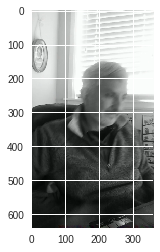

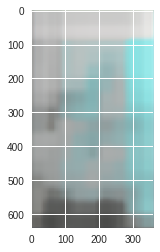

array([[[0.5944659 , 0.6409917 , 0.6432902 ],
        [0.5944659 , 0.6409917 , 0.6432902 ],
        [0.6551019 , 0.6820549 , 0.65407896],
        ...,
        [0.86121976, 0.89636624, 0.8758868 ],
        [0.78550327, 0.84993625, 0.8295599 ],
        [0.78550327, 0.84993625, 0.8295599 ]],

       [[0.5944659 , 0.6409917 , 0.6432902 ],
        [0.5944659 , 0.6409917 , 0.6432902 ],
        [0.6551019 , 0.6820549 , 0.65407896],
        ...,
        [0.86121976, 0.89636624, 0.8758868 ],
        [0.78550327, 0.84993625, 0.8295599 ],
        [0.78550327, 0.84993625, 0.8295599 ]],

       [[0.5875142 , 0.6372086 , 0.65917516],
        [0.5875142 , 0.6372086 , 0.65917516],
        [0.6598551 , 0.67038244, 0.6536249 ],
        ...,
        [0.8635613 , 0.89793825, 0.8925742 ],
        [0.78750813, 0.86121166, 0.85416466],
        [0.78750813, 0.86121166, 0.85416466]],

       ...,

       [[0.40909737, 0.43007296, 0.4301958 ],
        [0.40909737, 0.43007296, 0.4301958 ],
        [0.38952017, 0

In [9]:
%matplotlib inline

frame_num = 1

plt.imshow(frames_half[frame_num] * 1)
plt.show()

out_frames = autoencoder.predict(frames_half[frame_num:frame_num + 1], 
                                 batch_size = None, 
                                 verbose = 0,  
                                 steps = None)
  
plt.imshow(out_frames[0] * 1) #255 blows out of range probably due to normalization
plt.show()
  
display(out_frames[0] * 1)

In [5]:
#@title Shallow Convolutional AE with Data Augmentation { output-height: 11, display-mode: "both" }

## Model vars
encoding_dim = 128 #encoder compressed vector length
kernel_size = (3, 3)
strides = (2, 2)

## Training vars
batch_size = 8
epochs = 10
#frames_in = frames
frames_in = frames_half

## define keras model
#input_img = Input(shape=(INPUT_SIZE,))
#input_img = Input(shape=(720, 1280, 3))
input_img = Input(shape = frames_in[0].shape)

## "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Conv2D(filters = encoding_dim, 
                 kernel_size = kernel_size, 
                 strides = strides, 
                 padding = 'same', 
                 data_format = "channels_last", 
                 activation = 'relu'
                )(input_img)

## "decoded" is the lossy reconstruction of the input
#decoded = Dense(INPUT_SIZE, activation='sigmoid')(encoded)
decoded = Conv2DTranspose(frames_in.shape[3], 
                          kernel_size = kernel_size, 
                          strides = strides, 
                          padding = 'same', 
                          data_format = "channels_last", 
                          activation = 'sigmoid'
                         )(encoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
## retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
## create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
print(autoencoder.summary())

## data augmentation and batch normalization - inline with training
train_datagen = ImageDataGenerator(rotation_range = 20,
                                   width_shift_range =  0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                  )

#frames = train_datagen.standardize(frames) #crashy method won't work with uint8, throws...
#TypeError: Cannot cast ufunc multiply output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'
train_datagen.fit(frames_in) #required for featurewise_center

#autoencoder.fit(frames, frames, batch_size=4, epochs=2, shuffle=True)
autoencoder.fit(train_datagen.flow(frames_in, 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 640, 360, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 180, 128)     3584      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 640, 360, 3)       3459      
Total params: 7,043
Trainable params: 7,043
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============================] - 3s 518ms/step - loss: 5.0982
Epoch 2/10
6/6 [==============================] - 3s 434ms/step - loss: 4.4381
Epoch 3/10
6/6 [==============================] - 3s 453ms/step - loss: 4.2111
Epoch 4/10
6/6 [==============================] - 3s 433ms/step - loss: 4.2832
Epoch 5/10
6/6 [==============================] - 3s 448ms/step - loss: 4.2080
Epoc

In [6]:
#@title Additional Training Passes
epochs = 50 #@param {type:"integer"}

autoencoder.fit(train_datagen.flow(frames_in, 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )

Epoch 1/50
6/6 [==============================] - 3s 441ms/step - loss: 4.2521
Epoch 2/50
6/6 [==============================] - 3s 436ms/step - loss: 4.2259
Epoch 3/50
6/6 [==============================] - 3s 429ms/step - loss: 4.2481
Epoch 4/50
6/6 [==============================] - 3s 450ms/step - loss: 4.2299
Epoch 5/50
6/6 [==============================] - 3s 433ms/step - loss: 4.2112
Epoch 6/50
6/6 [==============================] - 3s 448ms/step - loss: 4.2102
Epoch 7/50
6/6 [==============================] - 3s 427ms/step - loss: 4.3303
Epoch 8/50
6/6 [==============================] - 3s 427ms/step - loss: 4.1965
Epoch 9/50
6/6 [==============================] - 3s 455ms/step - loss: 4.3072
Epoch 10/50
6/6 [==============================] - 3s 433ms/step - loss: 4.2277
Epoch 11/50
6/6 [==============================] - 3s 457ms/step - loss: 4.3211
Epoch 12/50
6/6 [==============================] - 3s 447ms/step - loss: 4.2577
Epoch 13/50
6/6 [==============================] 

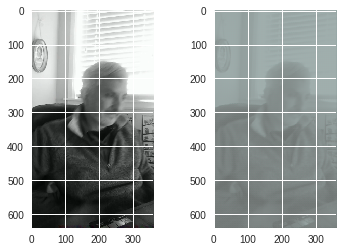

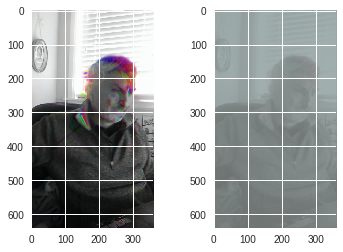

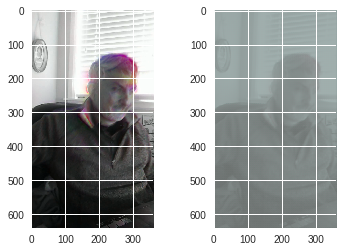

In [7]:
%matplotlib inline

#for i in range(1, frames.shape[0]): #return all frames
for i in range(1, 4): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  plt.show()
  


In [8]:
#@title Deep Convolutional AE (mixed kernel stack)

## Training vars
epochs = 10 #@param {type:"integer"}
batch_size = 8 #@param {type:"integer"}
#frames_in = frames
frames_in = frames_half

## Model vars
strides = (2, 2)
filters = 64 #@param {type:"integer"}

kernel_size1_1 = (3, 3)
kernel_size1_2 = (5, 5)
kernel_size2_1 = (3, 3)
kernel_size2_2 = (5, 5)
kernel_size3_1 = (5, 5)
kernel_size3_2 = (7, 7)
kernel_size4_1 = (5, 5)
kernel_size4_2 = (7, 7)


## define keras model
#input_img = Input(shape=(720, 1280, 3))
#input_img = Input(shape=(360, 640, 3))
input_img = Input(shape=frames_in[0].shape)

x = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(input_img)
x = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x = Conv2D(filters, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2D(filters, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x = Conv2D(filters, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2D(filters, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((5, 5), data_format = "channels_last", padding = 'same')(x)
x = Conv2D(filters, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2D(filters, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)

encoded = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)

## at this point the representation is (9, 16, filters)

x = Conv2DTranspose(filters, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(encoded)
x = Conv2DTranspose(filters, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D((5, 5), data_format = "channels_last")(x)
x = Conv2DTranspose(filters, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)

decoded = Conv2DTranspose(frames_in.shape[3], (1, 1), data_format = "channels_last", activation = 'sigmoid', padding = 'same')(x)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
## retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
## create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
print(autoencoder.summary())

## data augmentation and batch normalization - inline with training
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = False,
                                  )

#frames = train_datagen.standardize(frames) #crashy method won't work with uint8, throws...
#TypeError: Cannot cast ufunc multiply output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'
train_datagen.fit(frames_in) #required for featurewise_center

#autoencoder.fit(frames, frames, batch_size=4, epochs=2, shuffle=True)
autoencoder.fit(train_datagen.flow(frames_in,                 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 640, 360, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 640, 360, 128)     3584      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 640, 360, 128)     409728    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 320, 180, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 320, 180, 64)      73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 320, 180, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 90, 64)       0         
__________

In [19]:
#@title Additional Training Passes
epochs = 100 #@param {type:"integer"}

autoencoder.fit(train_datagen.flow(frames_in, 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )

Epoch 1/100
12/12 [==============================] - 10s 832ms/step - loss: 1.7963
Epoch 2/100
12/12 [==============================] - 10s 811ms/step - loss: 1.8074
Epoch 3/100
12/12 [==============================] - 10s 809ms/step - loss: 1.8295
Epoch 4/100
12/12 [==============================] - 10s 808ms/step - loss: 1.7949
Epoch 5/100
12/12 [==============================] - 10s 814ms/step - loss: 1.8019
Epoch 6/100
12/12 [==============================] - 10s 806ms/step - loss: 1.7934
Epoch 7/100
12/12 [==============================] - 10s 806ms/step - loss: 1.7948
Epoch 8/100
12/12 [==============================] - 10s 810ms/step - loss: 1.8013
Epoch 9/100
12/12 [==============================] - 10s 809ms/step - loss: 1.7869
Epoch 10/100
12/12 [==============================] - 10s 808ms/step - loss: 1.7886
Epoch 11/100
12/12 [==============================] - 10s 812ms/step - loss: 1.7909
Epoch 12/100
12/12 [==============================] - 10s 812ms/step - loss: 1.7839
E

frame number:  33


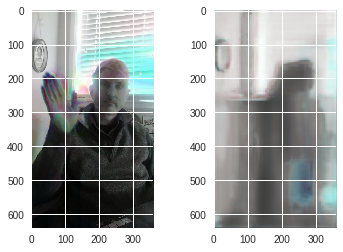

frame number:  34


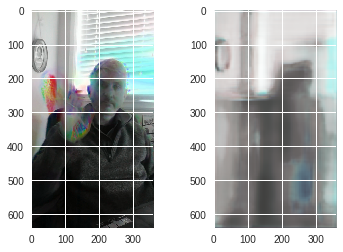

frame number:  35


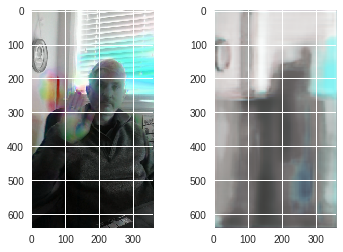

frame number:  36


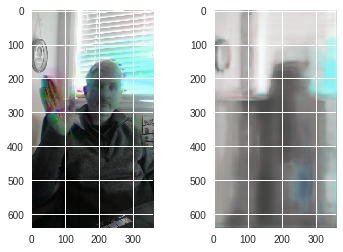

frame number:  37


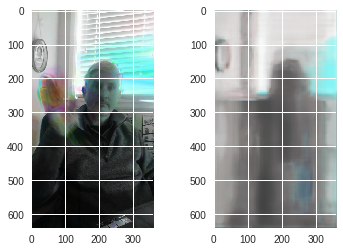

frame number:  38


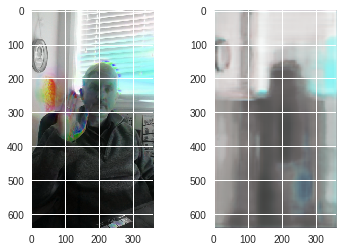

In [21]:
#@title Compare Model Input / Output (range)
%matplotlib inline

begin = 33 #@param {type:"integer"}
end = 38 #@param {type:"integer"}

#for i in range(1, frames_in.shape[0]): #return all frames
for i in range(begin, end + 1): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  print("frame number: ", i)
  plt.show()
  

Visualizing Latent Representations from first 11 frames


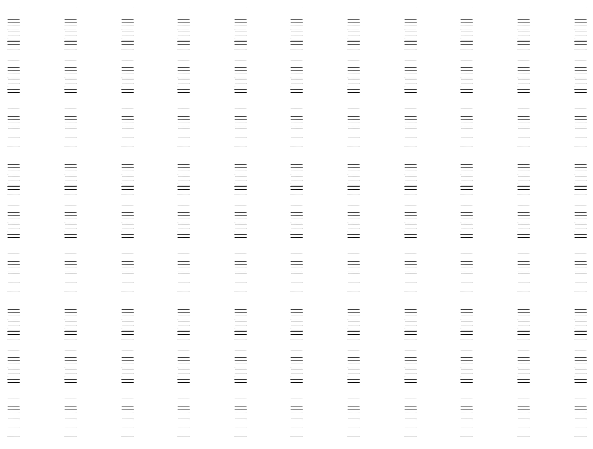

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 640, 360, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 640, 360, 128)     3584      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 640, 360, 128)     409728    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 320, 180, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 320, 180, 64)      73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 320, 180, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 90, 64)       0         
__________

In [11]:
#@title Peek at the layers (encoded representation)

## We can also have a look at the 128-dimensional encoded representations. 
## These representations are 8x4x4, so we reshape them to 4x32 
## in order to be able to display them as grayscale images

n=11 #@param {type:"integer"}

plt.figure(figsize=(n, 8))
for i in range(1, n + 1):
  ax = plt.subplot(1, n, i)
  encoded = encoder.predict(frames_in[i : i + 1], 
                            batch_size = None, 
                            verbose = 0, 
                            steps = None)
  encoded.shape[3]
  plt.imshow(encoded.reshape(encoded.shape[1], encoded.shape[2]*encoded.shape[3]).T)
  plt.gray
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
print("Visualizing Latent Representations from first", n, "frames")
plt.show()
  
  
print(encoder.summary())


In [24]:
#@title Deep/Wide Convolutional AE (Residual)
epochs = 10 #@param {type:"integer"}

## Training vars

#epochs = 10

batch_size = 4 #@param {type:"integer"}

#frames_in = frames
frames_in = frames_half 

## Model vars

strides = (2, 2) 

filters = 16 #@param {type:"integer"}

kernel_size1_1 = (1, 3)
kernel_size1_2 = (3, 1)
kernel_size2_1 = (3, 1)
kernel_size2_2 = (1, 3)
kernel_size3_1 = (1, 3)
kernel_size3_2 = (3, 1)
kernel_size4_1 = (3, 1)
kernel_size4_2 = (1, 3)


## define keras model
#input_img = Input(shape=(720, 1280, 3))
#input_img = Input(shape=(360, 640, 3))
input_img = Input(shape=frames_in[0].shape)
x_1 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_2 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
group = []
group = concatenate([x_1, x_2, input_img])
group = Conv2D(filters * 4, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 8, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_5 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_6 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_7 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_8 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x])
group = Conv2D(filters * 16, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D((5, 5), data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 16, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)

encoded = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x) # try GlobalAveragePooling2D

## at this point the representation is (16, 9, filters)

x = Conv2DTranspose(filters * 16, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(encoded)
x = Conv2DTranspose(filters * 16, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D((5, 5), data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 8, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 8, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 4, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 4, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)

decoded = Conv2DTranspose(frames_in.shape[3], (1, 1), data_format = "channels_last", activation = 'sigmoid', padding = 'same')(x)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
## retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
## create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
print(autoencoder.summary())

## data augmentation and batch normalization - inline with training
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = False,
                                  )

#frames = train_datagen.standardize(frames) #crashy method won't work with uint8, throws...
#TypeError: Cannot cast ufunc multiply output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'
train_datagen.fit(frames_in) #required for featurewise_center

#autoencoder.fit(frames, frames, batch_size=4, epochs=2, shuffle=True)
autoencoder.fit(train_datagen.flow(frames_in,                 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 640, 360, 3)  0                                            
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 640, 360, 32) 288         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_199 (Conv2D)             (None, 640, 360, 32) 288         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_100 (Bat (None, 640, 360, 32) 128         conv2d_198[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [30]:
#@title Additional Training Passes
epochs = 500 #@param {type:"integer"}

autoencoder.fit(train_datagen.flow(frames_in, 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )

Epoch 1/500
12/12 [==============================] - 19s 2s/step - loss: 1.8107
Epoch 2/500
12/12 [==============================] - 18s 2s/step - loss: 1.8057
Epoch 3/500
12/12 [==============================] - 18s 2s/step - loss: 1.8025
Epoch 4/500
12/12 [==============================] - 18s 2s/step - loss: 1.7947
Epoch 5/500
12/12 [==============================] - 18s 2s/step - loss: 1.7922
Epoch 6/500
12/12 [==============================] - 18s 2s/step - loss: 1.7987
Epoch 7/500
12/12 [==============================] - 18s 2s/step - loss: 1.8160
Epoch 8/500
12/12 [==============================] - 18s 2s/step - loss: 1.7979
Epoch 9/500
12/12 [==============================] - 18s 2s/step - loss: 1.7957
Epoch 10/500
12/12 [==============================] - 18s 2s/step - loss: 1.7928
Epoch 11/500
12/12 [==============================] - 18s 2s/step - loss: 1.7953
Epoch 12/500
12/12 [==============================] - 18s 2s/step - loss: 1.8012
Epoch 13/500
12/12 [=================

frame number:  33


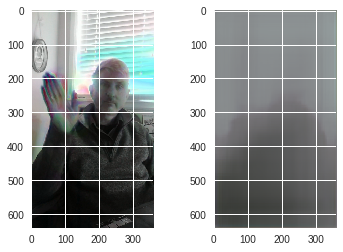

frame number:  34


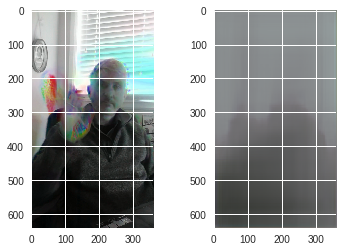

frame number:  35


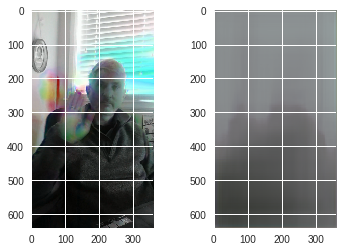

frame number:  36


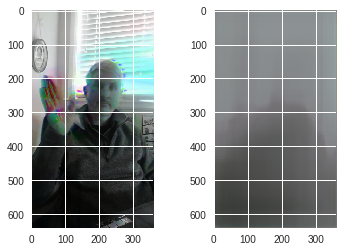

frame number:  37


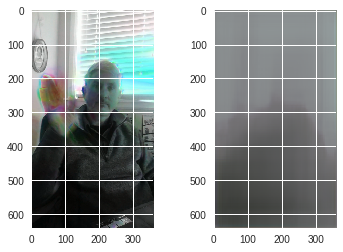

frame number:  38


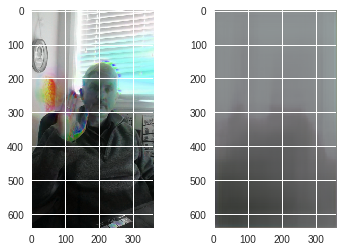

In [6]:
#@title Compare Model Input / Output (range)
%matplotlib inline

begin = 33 #@param {type:"integer"}
end = 38 #@param {type:"integer"}

#for i in range(1, frames_in.shape[0]): #return all frames
for i in range(begin, end + 1): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  print("frame number: ", i)
  plt.show()

In [0]:
#@title Additional Training Passes
epochs = 500 #@param {type:"integer"}

autoencoder.fit(train_datagen.flow(frames_in, 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = 500, 
                shuffle = True
               )

Epoch 1/500
12/12 [==============================] - 19s 2s/step - loss: 1.7643
Epoch 2/500
12/12 [==============================] - 18s 2s/step - loss: 1.7639
Epoch 3/500
12/12 [==============================] - 18s 2s/step - loss: 1.7669
Epoch 4/500
12/12 [==============================] - 18s 2s/step - loss: 1.7459
Epoch 5/500
12/12 [==============================] - 18s 2s/step - loss: 1.7657
Epoch 6/500
12/12 [==============================] - 18s 2s/step - loss: 1.7647
Epoch 7/500
12/12 [==============================] - 18s 2s/step - loss: 1.7684
Epoch 8/500
12/12 [==============================] - 18s 2s/step - loss: 1.7598
Epoch 9/500
12/12 [==============================] - 18s 2s/step - loss: 1.7564
Epoch 10/500
12/12 [==============================] - 18s 2s/step - loss: 1.7658
Epoch 11/500
12/12 [==============================] - 18s 2s/step - loss: 1.7570
Epoch 12/500
12/12 [==============================] - 18s 2s/step - loss: 1.7593
Epoch 13/500
12/12 [=================

frame number:  1


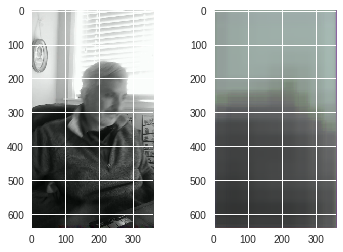

frame number:  2


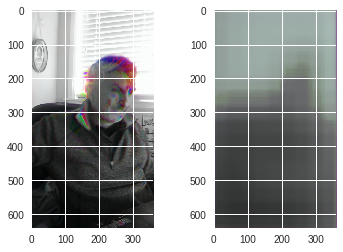

frame number:  3


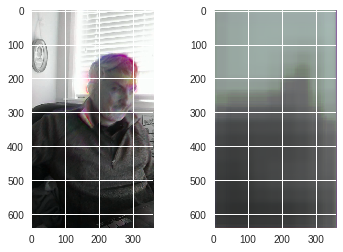

frame number:  4


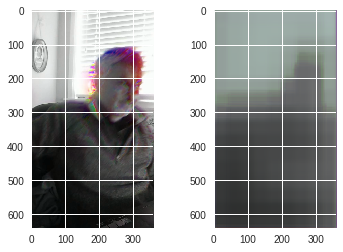

frame number:  5


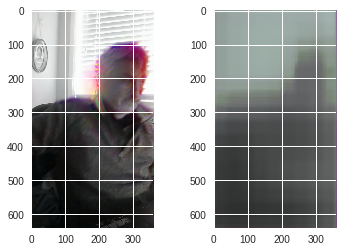

frame number:  6


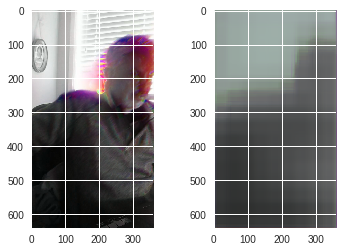

frame number:  7


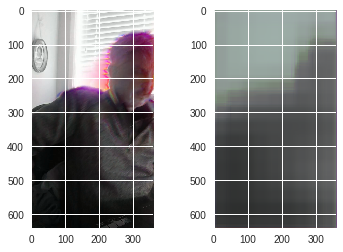

frame number:  8


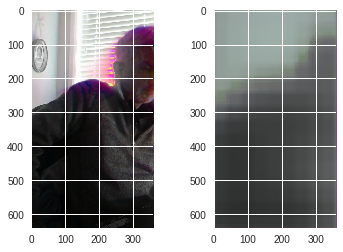

frame number:  9


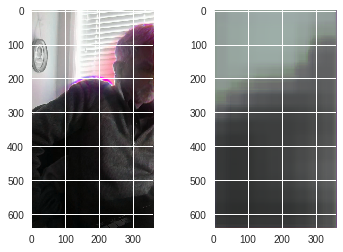

frame number:  10


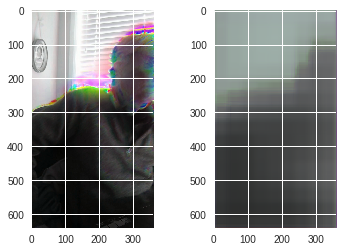

frame number:  11


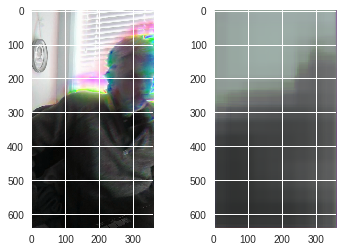

frame number:  12


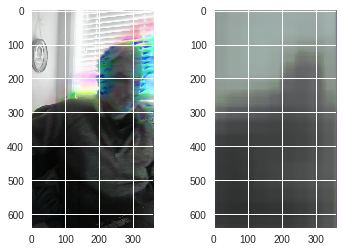

frame number:  13


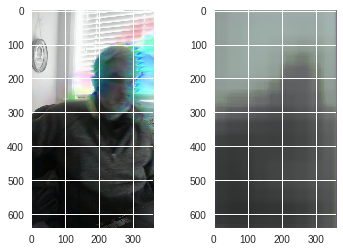

frame number:  14


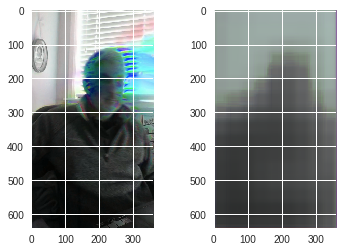

frame number:  15


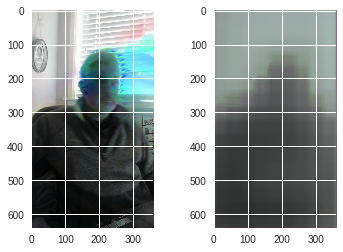

frame number:  16


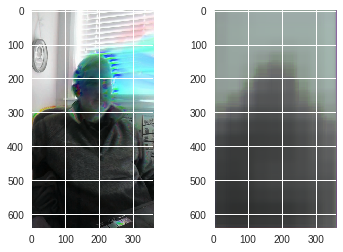

frame number:  17


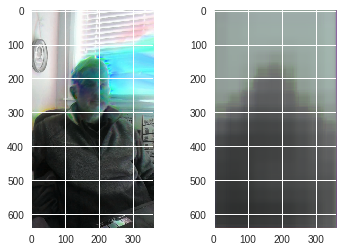

frame number:  18


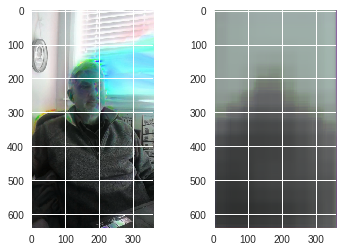

frame number:  19


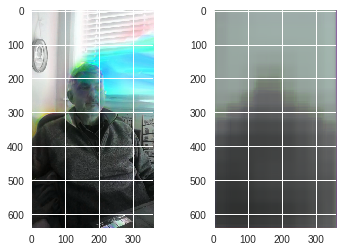

frame number:  20


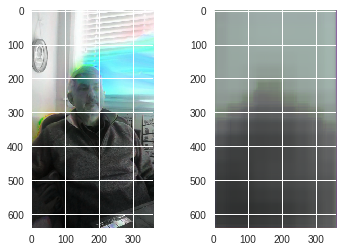

frame number:  21


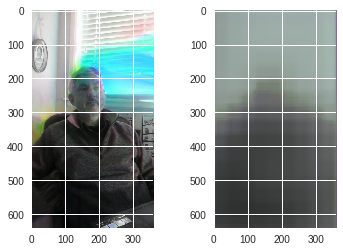

frame number:  22


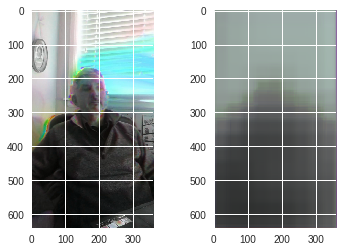

frame number:  23


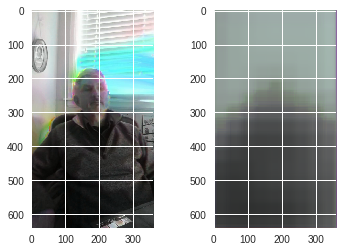

frame number:  24


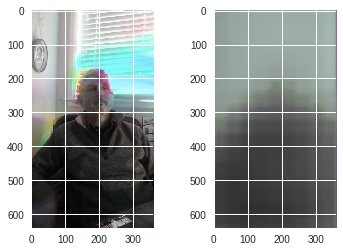

frame number:  25


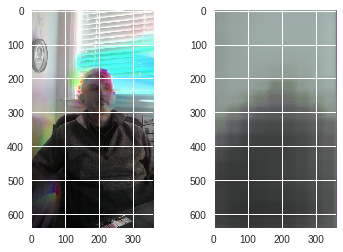

frame number:  26


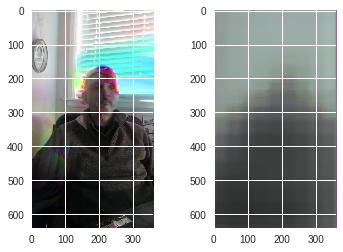

frame number:  27


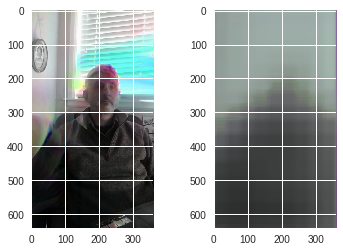

frame number:  28


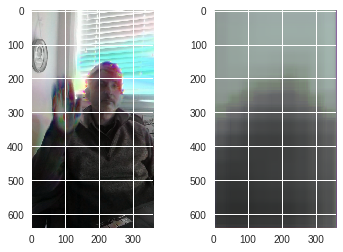

frame number:  29


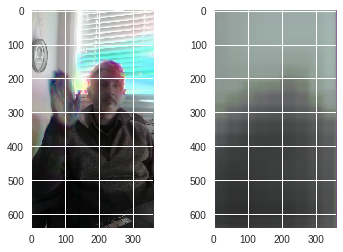

frame number:  30


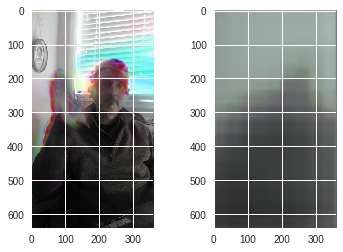

frame number:  31


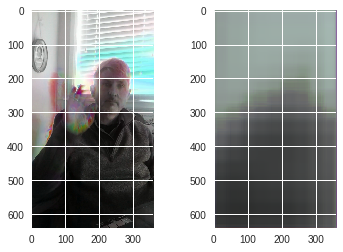

frame number:  32


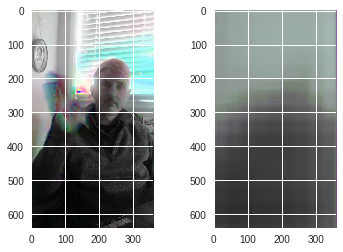

frame number:  33


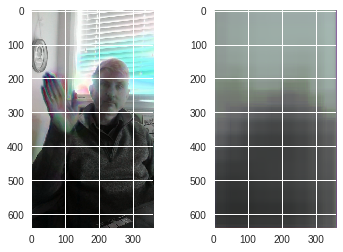

frame number:  34


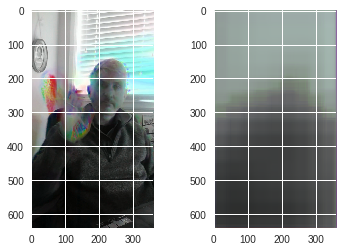

frame number:  35


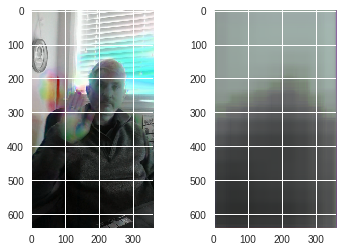

frame number:  36


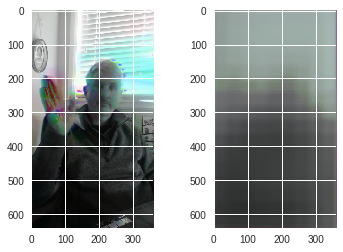

frame number:  37


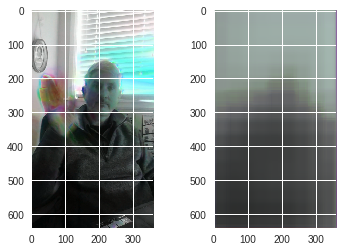

frame number:  38


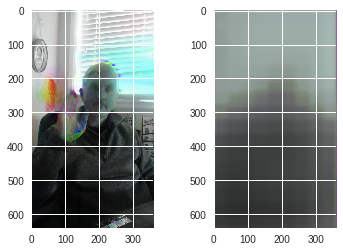

frame number:  39


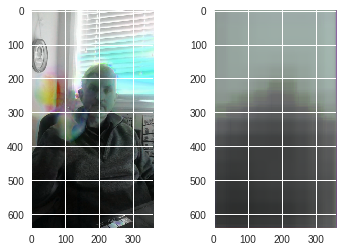

frame number:  40


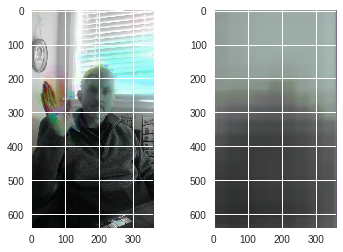

frame number:  41


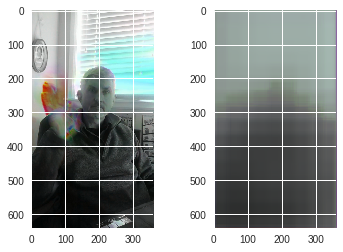

frame number:  42


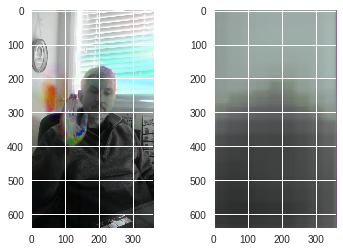

frame number:  43


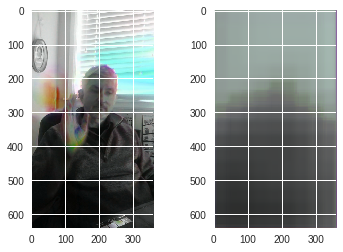

frame number:  44


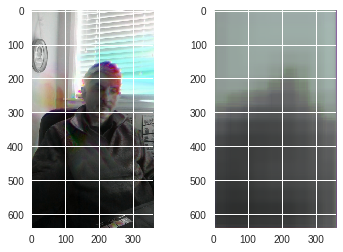

frame number:  45


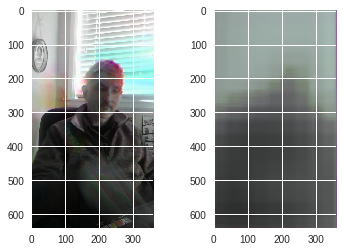

frame number:  46


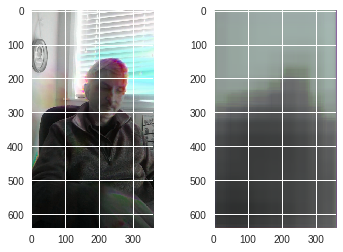

In [9]:
#@title Compare Model Input / Output (ALL FRAMES)
%matplotlib inline

begin = 33
end = 38

for i in range(1, frames_in.shape[0]): #return all frames
#for i in range(begin, end + 1): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  print("frame number: ", i)
  plt.show()

# **DRAG RACE**: Comparing layer costs for stacking 3x3 vs alternating 1 x 3 pairs

In [12]:
#@title (3x3) Triple StackedDeep/Wide Convolutional AE

## Training vars

epochs = 100

batch_size = 4

#frames_in = frames
frames_in = frames_half

## Model vars

strides = (2, 2)

filters = 4

kernel_size1_1 = (3, 3)
kernel_size1_2 = (3, 3)
kernel_size2_1 = (3, 3)
kernel_size2_2 = (3, 3)
kernel_size3_1 = (3, 3)
kernel_size3_2 = (3, 3)
kernel_size4_1 = (3, 3)
kernel_size4_2 = (3, 3)


## define keras model
#input_img = Input(shape=(720, 1280, 3))
#input_img = Input(shape=(360, 640, 3))
input_img = Input(shape=frames_in[0].shape)
x_1 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_2 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
group = []
group = concatenate([x_1, x_2, input_img])
group = Conv2D(filters * 4, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 8, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_5 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_6 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_7 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_8 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x])
group = Conv2D(filters * 16, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D((5, 5), data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 16, (3, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)

encoded = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x) # try GlobalAveragePooling2D

## at this point the representation is (16, 9, filters)

x = Conv2DTranspose(filters * 16, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(encoded)
x = Conv2DTranspose(filters * 16, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D((5, 5), data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 8, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 8, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 4, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 4, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)

decoded = Conv2DTranspose(frames_in.shape[3], (1, 1), data_format = "channels_last", activation = 'sigmoid', padding = 'same')(x)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
## retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
## create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
print(autoencoder.summary())

## data augmentation and batch normalization - inline with training
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = False,
                                  )

#frames = train_datagen.standardize(frames) #crashy method won't work with uint8, throws...
#TypeError: Cannot cast ufunc multiply output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'
train_datagen.fit(frames_in) #required for featurewise_center

#autoencoder.fit(frames, frames, batch_size=4, epochs=2, shuffle=True)
autoencoder.fit(train_datagen.flow(frames_in,                 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )







__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 640, 360, 3)  0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 640, 360, 8)  216         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 640, 360, 8)  216         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_162 (Bat (None, 640, 360, 8)  32          conv2d_170[0][0]                 
__________________________________________________________________________________________________
batch_norm

frame number:  33


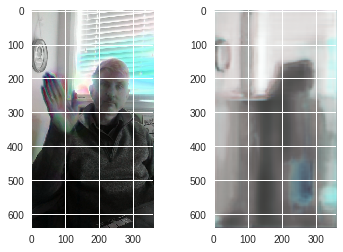

frame number:  34


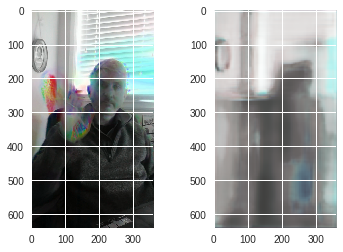

frame number:  35


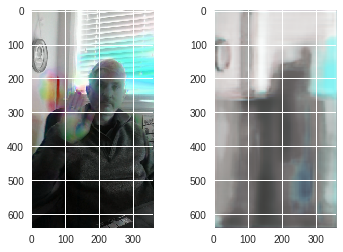

frame number:  36


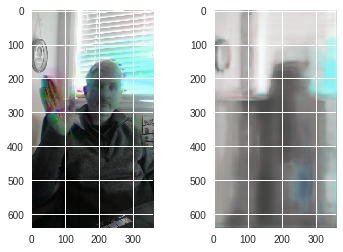

frame number:  37


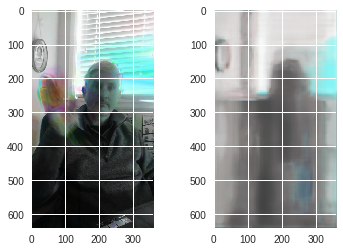

frame number:  38


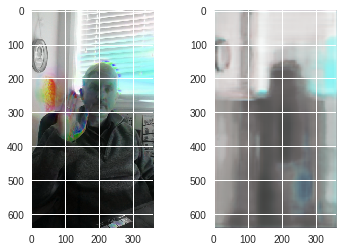

In [20]:
#@title Compare Model Input / Output (range)
%matplotlib inline

begin = 33 #@param {type:"integer"}
end = 38 #@param {type:"integer"}

#for i in range(1, frames_in.shape[0]): #return all frames
for i in range(begin, end + 1): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  print("frame number: ", i)
  plt.show()

In [16]:
#@title (1x3)(3x1) Triple Stacked Deep/Wide Convolutional AE

## Training vars

epochs = 100

batch_size = 4

#frames_in = frames
frames_in = frames_half

## Model vars

strides = (2, 2)

filters = 4

kernel_size1_1 = (1, 3)
kernel_size1_2 = (3, 1)
kernel_size2_1 = (3, 1)
kernel_size2_2 = (1, 3)
kernel_size3_1 = (1, 3)
kernel_size3_2 = (3, 1)
kernel_size4_1 = (3, 1)
kernel_size4_2 = (1, 3)


## define keras model
#input_img = Input(shape=(720, 1280, 3))
#input_img = Input(shape=(360, 640, 3))
input_img = Input(shape=frames_in[0].shape)
x_1 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_2 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(input_img)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_1 = Conv2D(filters * 2, kernel_size1_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 2, kernel_size1_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
group = []
group = concatenate([x_1, x_2, input_img])
group = Conv2D(filters * 4, (1, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
group = Conv2D(filters * 4, (3, 1), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 4, kernel_size2_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 4, kernel_size2_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 8, (3, 1), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
group = Conv2D(filters * 8, (1, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(groups)
#x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_5 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_6 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_7 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_8 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_5 = LeakyReLU(alpha=0.05)(x_5)
x_6 = LeakyReLU(alpha=0.05)(x_6)
x_7 = LeakyReLU(alpha=0.05)(x_7)
x_8 = LeakyReLU(alpha=0.05)(x_8)
x_1 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_5 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_5)
x_6 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_6)
x_7 = Conv2D(filters * 8, kernel_size3_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_7)
x_8 = Conv2D(filters * 8, kernel_size3_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_8)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_5 = BatchNormalization()(x_5)
x_6 = BatchNormalization()(x_6)
x_7 = BatchNormalization()(x_7)
x_8 = BatchNormalization()(x_8)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x])
group = Conv2D(filters * 16, (3, 1), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
group = Conv2D(filters * 16, (1, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)
x = MaxPooling2D((5, 5), data_format = "channels_last", padding = 'same')(x)
x_1 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_2 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_3 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_4 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
x_1 = LeakyReLU(alpha=0.05)(x_1)
x_2 = LeakyReLU(alpha=0.05)(x_2)
x_3 = LeakyReLU(alpha=0.05)(x_3)
x_4 = LeakyReLU(alpha=0.05)(x_4)
x_1 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_1)
x_2 = Conv2D(filters * 16, kernel_size4_2, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_2)
x_3 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_3)
x_4 = Conv2D(filters * 16, kernel_size4_1, data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(x_4)
x_1 = BatchNormalization()(x_1)
x_2 = BatchNormalization()(x_2)
x_3 = BatchNormalization()(x_3)
x_4 = BatchNormalization()(x_4)
group = []
group = concatenate([x_1, x_2, x_3, x_4, x])
group = Conv2D(filters * 16, (1, 3), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
group = Conv2D(filters * 16, (3, 1), data_format = "channels_last", activation = None, use_bias = False, padding = 'same')(group)
#x = concatenate(group)
x = LeakyReLU(alpha=0.05)(group)

encoded = MaxPooling2D(strides, data_format = "channels_last", padding = 'same')(x) # try GlobalAveragePooling2D

## at this point the representation is (16, 9, filters)

x = Conv2DTranspose(filters * 16, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(encoded)
x = Conv2DTranspose(filters * 16, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 16, kernel_size4_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 16, kernel_size4_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D((5, 5), data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 8, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 8, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 8, kernel_size3_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 8, kernel_size3_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 4, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 4, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 4, kernel_size2_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 4, kernel_size2_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)
x = Conv2DTranspose(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_1, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(filters * 2, kernel_size1_2, data_format = "channels_last", activation = 'relu', padding = 'same')(x)
x = UpSampling2D(strides, data_format = "channels_last")(x)

decoded = Conv2DTranspose(frames_in.shape[3], (1, 1), data_format = "channels_last", activation = 'sigmoid', padding = 'same')(x)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
## retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
## create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
print(autoencoder.summary())

## data augmentation and batch normalization - inline with training
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = False,
                                  )

#frames = train_datagen.standardize(frames) #crashy method won't work with uint8, throws...
#TypeError: Cannot cast ufunc multiply output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'
train_datagen.fit(frames_in) #required for featurewise_center

#autoencoder.fit(frames, frames, batch_size=4, epochs=2, shuffle=True)
autoencoder.fit(train_datagen.flow(frames_in,                 
                                   frames_in, 
                                   batch_size = batch_size), 
                steps_per_epoch = len(frames_in) / batch_size, 
                epochs = epochs, 
                shuffle = True
               )








__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 640, 360, 3)  0                                            
__________________________________________________________________________________________________
conv2d_340 (Conv2D)             (None, 640, 360, 8)  72          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_341 (Conv2D)             (None, 640, 360, 8)  72          input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_324 (Bat (None, 640, 360, 8)  32          conv2d_340[0][0]                 
__________________________________________________________________________________________________
batch_norm

frame number:  33


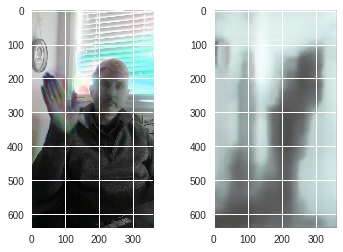

frame number:  34


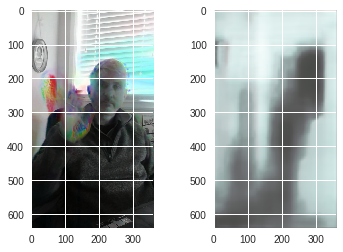

frame number:  35


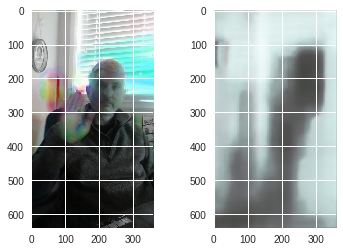

frame number:  36


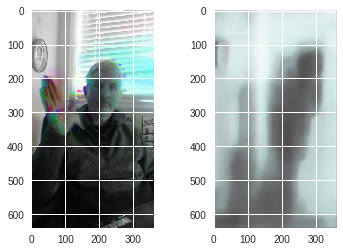

frame number:  37


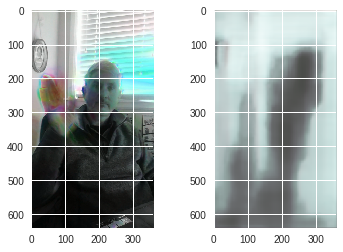

frame number:  38


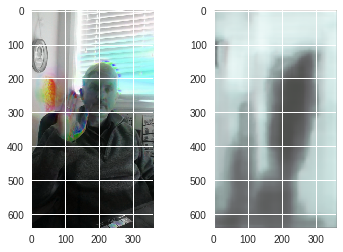

In [17]:
#@title Compare Model Input / Output (range)
%matplotlib inline

begin = 33 #@param {type:"integer"}
end = 38 #@param {type:"integer"}

#for i in range(1, frames_in.shape[0]): #return all frames
for i in range(begin, end + 1): #only return range
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(frames_in[i] * 1)
  out_frames = autoencoder.predict(frames_in[i : i + 1], 
                                   batch_size = None, 
                                   verbose = 0, 
                                   steps = None)
  axarr[1].imshow(out_frames[0] * 1)
  print("frame number: ", i)
  plt.show()

## In Progress / Backlog

In [0]:
## Play video of input and returned frames

#https://stackoverflow.com/questions/47138023/matplotlib-animation-in-jupyter-notebook-creates-additional-empty-plot
#print(frames_in.shape[0])
#%matplotlib qt
%matplotlib inline
import matplotlib.animation
import time

i = 0

def grab_inframe(i):
  return(frames_in[i])

def grab_outframe(i):
  return(out_frames[i])


#build plots  
fig, axarr = plt.subplots(1, 2)
    
inframe = axarr[0].imshow(grab_inframe(0), animated=True)
outframe = axarr[1].imshow(grab_outframe(0), animated=True)


def play_in(i):
  global frames_in
  inframe.set_array(frames_in[i])
  return inframe,
  #time.sleep(0.1)
  #i+=1
    
def play_out(i):
  global out_frames
  outframe.set_array(out_frames[i])
  return outframe,
  #time.sleep(0.1)
  #i+=1

#generate output frames
out_frames = autoencoder.predict(frames_in[:], 
                                   batch_size = None, #try batch_size = len(frames_in)
                                   verbose = 0, 
                                   steps = None)


#set up lists of images for animations
l_frames_in, l_out_frames = [], []  
for i in range(frames_in.shape[0]):
  #frame_in, = frames_in[i].tolist()
  inframe = axarr[0].imshow(frames_in[i], animated=True)
  #out_frame, = out_frames[i].tolist()
  outframe = axarr[1].imshow(grab_outframe(i), animated=True)
  l_frames_in.append([inframe,])
  l_out_frames.append([outframe,])
  plt.show()

  
inframe = matplotlib.animation.FuncAnimation(fig, play_in, interval=1000, blit=True)
outframe = matplotlib.animation.FuncAnimation(fig, play_out, interval=500, blit=False)

#inframe = matplotlib.animation.FuncAnimation(fig, l_frames_in, interval=1000, blit=True)
#outframe = matplotlib.animation.FuncAnimation(fig, l_out_frames, interval=500, blit=False)

plt.show()



In [0]:
## Integrate training analytics

#tensorboard --logdir=/tmp/autoencoder

#https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6
#https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

In [0]:
## Here's how we will generate synthetic noisy digits: we just apply 
## a gaussian noise matrix and clip the images between 0 and 1.

#noise_factor = 0.5
#x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
#x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Here's what the noisy digits look like:

#n = 10
#plt.figure(figsize=(20, 2))
#for i in range(n):
#    ax = plt.subplot(1, n, i)
#    plt.imshow(x_test_noisy[i].reshape(28, 28))
#    plt.gray()
#    ax.get_xaxis().set_visible(False)
#    ax.get_yaxis().set_visible(False)
#plt.show()

In [0]:
### Temporal Auto Encoder - Sequence-to-sequence autoencoder from F Chollet Tutorial



#https://srirangatarun.wordpress.com/2018/07/09/video-frame-prediction-with-keras/



## From F Chollet Tutorial
## If you inputs are sequences, rather than vectors or 2D images, 
## then you may want to use as encoder and decoder a type of model 
## that can capture temporal structure, such as a LSTM. To build a 
## LSTM-based autoencoder, first use a LSTM encoder to turn your 
## input sequences into a single vector that contains information about 
## the entire sequence, then repeat this vector n times 
## (where n is the number of timesteps in the output sequence), and run 
## a LSTM decoder to turn this constant sequence into the target sequence.

#from keras.layers import Input, LSTM, RepeatVector
#from keras.models import Model

#seq_inputs = Input(shape=(timesteps, input_dim))
#seq_encoded = LSTM(latent_dim)(seq_inputs)

#seq_decoded = RepeatVector(timesteps)(seq_encoded)
#seq_decoded = LSTM(input_dim, return_sequences=True)(seq_decoded)

#seq_autoencoder = Model(seq_inputs, seq_decoded)
#seq_encoder = Model(seq_inputs, seq_encoded)

In [0]:
### VAE Example

## Github as a standalone script
## https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [0]:
## Train with intermediate save points with count of aggregate epochs

#define a counter for epochs

#define a model instance naming convention

#define a consistent parameter coding scheme to append name

#trigger save every 100 epochs

#manual save function

#manual restore function

#test with manual and triggered saves

In [0]:
### Hyperparameter Tuning

#hyperas
#http://maxpumperla.com/hyperas/
#https://github.com/maxpumperla/hyperas
#https://towardsdatascience.com/keras-hyperparameter-tuning-in-google-colab-using-hyperas-624fa4bbf673

#hyperas example on two model comparison with dropout optimizations
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [0]:
## replace Conv2D with ConvLSTM2D or gruCNN 
## or some other encoding arch alternative to Classic ConvNets


#https://keras.io/layers/recurrent/

keras.layers.ConvLSTM2D(filters, 
                        kernel_size, 
                        strides=(1, 1), 
                        padding='valid', 
                        data_format=None, 
                        dilation_rate=(1, 1), 
                        activation='tanh', 
                        recurrent_activation='hard_sigmoid', 
                        use_bias=True, 
                        kernel_initializer='glorot_uniform', 
                        recurrent_initializer='orthogonal', 
                        bias_initializer='zeros', 
                        unit_forget_bias=True, 
                        kernel_regularizer=None, 
                        recurrent_regularizer=None, 
                        bias_regularizer=None, 
                        activity_regularizer=None, 
                        kernel_constraint=None, 
                        recurrent_constraint=None, 
                        bias_constraint=None, 
                        return_sequences=False, 
                        go_backwards=False, 
                        stateful=False, 
                        dropout=0.0, 
                        recurrent_dropout=0.0)



In [0]:
### scale up processing on steppings of GPUs

#https://cloud.google.com/ml-engine/docs/tensorflow/using-gpus

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
### Massive Pretraining

In [0]:
### Test-Train split the frames for measurement of transfer learning 


In [0]:
### Add Classifier for benchmark datasets